In [ ]:
"""
@Josh Boquiren
OTIS Lab MUSC
6.22.2023
"""

## Pilot

In [ ]:
#import libraries

#data manipulation
import numpy as np
import pandas as pd

#plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#directory and file manager
import os

#statistics
import scipy.stats as stats
import scipy.io as sio


In [ ]:
#initialize directories

try:
    user = 'jboqu'

    #project datasets folder in DropBox
    basedir = r'C:\Users\%s\Dropbox\2P Imaging Projects\Beth\Josh\Project Datasets\LC-PrL DREADDs Self Admin Analysis\Controls'%(user)
    cueRein_dir = os.path.join(basedir, 'CueRein')
    cueReinCNO_dir = os.path.join(basedir, 'CueReinCNO')
    cueReinPersist_dir = os.path.join(basedir, 'CueReinPersist')

    #folders in repository
    repository = r'C:\Users\%s\Dropbox\2P Imaging Projects\Beth\Josh\Repositories\LC-PrL-DREADDs_Self-Admin_Analysis\cue_analysis\LCDD'%(user)
    results = os.path.join(repository, 'results')
    models = os.path.join(repository, 'population_data')

    #cluster list files
    cueRein_cluster_labels = np.load(os.path.join(cueRein_dir, 'cluster_list_per_session_CueTests Control.npy'))
    cueReinCNO_labels = np.load(os.path.join(cueReinCNO_dir, 'cluster_list_per_session_CueTests Control.npy'))
    cueReinPersist_labels = np.load(os.path.join(cueReinPersist_dir, 'cluster_list_per_session_CueTests Control.npy'))

except:
    user = 'OtisLab'

    #project datasets folder in DropBox
    basedir = r'C:\Users\%s\Dropbox\2P Imaging Projects\Beth\Josh\Project Datasets\LC-PrL DREADDs Self Admin Analysis\Controls'%(user)
    cueRein_dir = os.path.join(basedir, 'CueRein')
    cueReinCNO_dir = os.path.join(basedir, 'CueReinCNO')
    cueReinPersist_dir = os.path.join(basedir, 'CueReinPersist')

    #folder in repository
    repository = r'C:\Users\%s\Dropbox\2P Imaging Projects\Beth\Josh\Repositories\LC-PrL-DREADDs_Self-Admin_Analysis\cue_analysis\LCDD'%(user)
    results = os.path.join(repository, 'results')
    models = os.path.join(repository, 'population_data')

    #cluster list files
    cueRein_cluster_labels = np.load(os.path.join(cueRein_dir, 'cluster_list_per_session_CueTests Control.npy'))
    cueReinCNO_labels = np.load(os.path.join(cueReinCNO_dir, 'cluster_list_per_session_CueTests Control.npy'))
    cueReinPersist_labels = np.load(os.path.join(cueReinPersist_dir, 'cluster_list_per_session_CueTests Control.npy'))

print('User:', user)
print('Base directory:', basedir)
print('Results directory:', results)

#for later plot titles
plot_titles = ['CueRein', 'CueReinCNO', 'CueReinPersist']
population_title = 'LCDD'

#animals of interest
cueRein_animals = [
    'LCDD-PGa4',
    'LCDD-PGa5',
    'LCDD-PGa6',

    'PGa-T1',
    'PGa-T2',
    'PGa-T3'
    ]  
cueReinCNO_animals = [
    'LCDD-PGa4',
    'LCDD-PGa5',
    'LCDD-PGa6',

    'PGa-T1',
    'PGa-T2',
    ]  
cueReinPersist_animals = [ 
    'LCDD-PGa4',
    'LCDD-PGa5',
    'LCDD-PGa6',

    'PGa-T1',
    'PGa-T2',
    'PGa-T3'
    ]  

In [ ]:
#frame rate variables
frameaveraging = 4
timebetweenframes = 33.3333
framerate = 30
framerate = timebetweenframes/frameaveraging #raw frame rate
averagedframerate = timebetweenframes/frameaveraging #averaged frame rate
print('Frame rate:', framerate)
print('Averaged frame rate:', averagedframerate)

#window size variables
pre_window_size = int(10*framerate)
window_size =  int((pre_window_size*2)+(3*framerate))
post_window_size = window_size - pre_window_size
baselinefirstframe = 0
baselinelastframe = int(1*framerate)
infusionframe = int(pre_window_size+(3*framerate))
print('Prewindow size:', pre_window_size)
print('Window size:', window_size)
print('Postwindow size:', post_window_size)

#set cell tracking
tracking = 'No' ### 'Yes' or 'No'
sorting = 'Yes' ### 'Yes' or 'No'
sorttoearly = 'No' ###'Yes' or 'No'; This is for sorting, but align to early data. 'Sorting' must also be Yes
csv_id_for_tracking = 'CUE-DRUG-TMT'

#tracking
if tracking == 'Yes':
    population_active_tracked_early = np.nan*np.ones((1,window_size))
    population_active_tracked_middle = np.nan*np.ones((1,window_size))
    population_active_tracked_late = np.nan*np.ones((1,window_size))
    print ('Cell Tracking')
else:
    print ('No Cell Tracking')

## Population Analysis

### Preprocessing

In [ ]:
#method for fixing dropped frames
def fix_any_dropped_frames(frame_timestamps):
    first_frame = np.array([0])
    last_frame = np.array([int(np.max(frame_timestamps)+(500*timebetweenframes))])
    frame_index_temp = np.concatenate((first_frame,frame_timestamps, last_frame)) ###adds frame to timepoint '0' and an extra 500 frames at end
    frames_missed = [] ###creates empty list for us to add timestamps for missed frames
    for i in range(len(frame_index_temp)-1): ###iterates through each collected frame
            numframes_missed = int(np.round((frame_index_temp[i+1]-frame_index_temp[i])\
                /timebetweenframes)-1) ### number of missed frames per frame interval
            if numframes_missed > 0: 
                for j in range(numframes_missed):
                    frame_missed = np.array([frame_index_temp[i] + (int(timebetweenframes * (j+1)))])
                    frames_missed = np.concatenate((frames_missed, frame_missed))
    corrected_frame_index = np.array(sorted(np.concatenate((frame_index_temp, frames_missed))))
    return corrected_frame_index

#method for fixing assumed frames
def fix_assumed_frames(frames):
    dropped_frames = []
    diff_frames = np.diff(frames)
    inter_frame_interval = 33
    frame_drop_idx = np.where(diff_frames>1.5*inter_frame_interval)[0]
    for idx in frame_drop_idx:
        numframesdropped = int(np.round((frames[idx+1]-frames[idx])/(inter_frame_interval+0.0))-1)
        temp = [frames[idx]+a*inter_frame_interval for a in range(1,numframesdropped+1)]
        dropped_frames.extend(temp)
    corrected_frames = np.sort(np.concatenate((frames, np.array(dropped_frames))))
    return corrected_frames

#generate behavior data
try:
    assumed_frames = np.load(os.path.join(models, 'assumed_frames.npy'))
    assumed_frame_timestamps = np.load(os.path.join(models, 'assumed_frame_timestamps.npy'))
    print("Loaded behavior data.")
except:
    #load in data
    print('Processing data...')
    behaviordata_noframes = sio.loadmat(r"C:\Users\%s\Dropbox\2P Imaging Projects\Beth\Josh\Project Datasets\LC-PrL DREADDs Self Admin Analysis\Controls\Codes\matfile_noframes_3.mat"%(user))
    eventlog_noframes = np.squeeze(behaviordata_noframes['eventlog'])

    #parse desired data
    max_of_eventlog_noframes = max(eventlog_noframes[:,1]) #all rows, second column
    length_of_eventlog_noframes = len(eventlog_noframes[:,1])
    x = np.vstack((eventlog_noframes, eventlog_noframes, eventlog_noframes))
    x[length_of_eventlog_noframes:,1]= x[length_of_eventlog_noframes:,1]+max_of_eventlog_noframes
    x[length_of_eventlog_noframes*2:,1]= x[length_of_eventlog_noframes*2:,1]+(2*max_of_eventlog_noframes)
    eventlog_noframes = x

    assumed_frames = fix_any_dropped_frames(eventlog_noframes[eventlog_noframes[:,0]==9,1]) ###Fixes issue for finding behavior IF YOU DON"T HAVE FRAME INFO
    assumed_frame_timestamps = fix_assumed_frames(eventlog_noframes[eventlog_noframes[:,0]==9,1]) ###Fixes issue for finding behavior IF YOU DON"T HAVE FRAME INFO

    np.save(os.path.join(models, 'assumed_frames'), assumed_frames)
    np.save(os.path.join(models, 'assumed_frame_timestamps'), assumed_frame_timestamps)
    print("Behavior data processed and loaded.")


In [ ]:
#various methods

def fit_regression(x, y):
    lm = sm.OLS(y, sm.add_constant(x)).fit()
    x_range = sm.add_constant(np.array([x.min(), x.max()]))
    x_range_pred = lm.predict(x_range)
    return lm.pvalues[1], lm.params[1], x_range[:,1], x_range_pred, lm.rsquared

def CDFplot(x, ax, color=None, label='', linetype='-'):
    x = np.array(x)
    ix=np.argsort(x)
    ax.plot(x[ix], ECDF(x)(x)[ix], linetype, color=color, label=label)
    return ax

def fit_regression_and_plot(x, y, ax, plot_label='', color='k', markersize=3):
    #linetype is a string like 'bo'
    pvalue, slope, temp, temppred, R2 = fit_regression(x, y)    
    ax.scatter(x, y, color=color, label='%s p=%.3f\nR$^2$=%.3f'% (plot_label, pvalue, R2), s=markersize)
    ax.plot(temp, temppred, color=color)
    return ax, slope, pvalue, R2

def ismembertol(x, y, tol=1E-6):
    # Are elements of x in y within tolerance of tol?
    # x and y must be 1d numpy arrays
    sortx = np.sort(x)
    orderofx = np.argsort(x)
    sorty = np.sort(y)
    current_y_idx = 0
    result = np.nan*np.zeros(x.shape)
    for i, elt in enumerate(sortx):
        temp = sorty[current_y_idx:]
        if np.any(np.abs(temp-elt)<=tol):
            result[orderofx[i]]=1
        else:
            result[orderofx[i]]=0
        temp = np.argwhere(sorty>elt)
        if temp.size>0:
            current_y_idx = temp[0][0]
    return result

def mkdir_p(path):
    #makes a new directory if it doesn't exist
    try:
        os.makedirs(path)
    except OSError as exc: # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise 
            
def framenumberforevent(event, frame_timestamps):
    framenumber = np.nan*np.zeros(event.shape)
    for ie, e in enumerate(event):
        #print('     e:', e)
        if np.isnan(e):
            framenumber[ie] = np.nan
        else:
            temp = np.nonzero(frame_timestamps<=e)[0]
            if temp.shape[0]>0:
                framenumber[ie] = np.nonzero(frame_timestamps<=e)[0][-1]
            else:
                framenumber[ie] = 0
    return framenumber

def calculate_num_licks_for_each_frame(framenumberforlicks, numframes):
    numlicksperframe = np.nan*np.ones((numframes,))
    for i in range(numframes):
        numlicksperframe[i] = np.sum(framenumberforlicks==i)
    return numlicksperframe

def calculate_auROC(x,y,offset_to_zero=True):
    U, p = stats.mannwhitneyu(x,y)
    labels = np.concatenate((np.ones(x.shape), np.zeros(y.shape)))
    data = np.concatenate((x,y))
    A = auROC(labels, data)
    if offset_to_zero:
        return (2*(A-0.5), p)
    else:
        return (A, p)
    
def Benjamini_Hochberg_correction(vector_of_pvals,
                                  alpha = 0.05):
    # This function ipltements the BH FDR correction
    
    # Parameters:
    # Vector of p values from the different tests
    # alpha:significance level
    
    # Returns: Corrected p values. All the p values that are above the FDR threshold are set to 1. 
    #          Remaining p values are unchanged.
    
    sortedpvals = np.sort(vector_of_pvals)
    orderofpvals = np.argsort(vector_of_pvals)
    m = sortedpvals[np.isfinite(sortedpvals)].shape[0] #Total number of hypotheses
    for i in range(m):
        if sortedpvals[i] > (i+1)*alpha/m:
            k = i
            break
        elif i == m-1:
            k = m-1
        
    correctedpvals = np.copy(vector_of_pvals)
    correctedpvals[orderofpvals[k:]] = 1
    correctedpvals[np.isnan(vector_of_pvals)] = np.nan
    return correctedpvals

In [ ]:
#method for animal analysis
def analyze_single_session(indir, window_size, pre_window_size):    
    tempfiles = next(os.walk(indir))[2]
    npyfiles = [f for f in tempfiles if os.path.splitext(f)[1]=='.npy' 
        and 'extractedsignals_raw' in f]
    matfiles = [f for f in tempfiles if os.path.splitext(f)[1]=='.mat']

    if len(npyfiles) > 1:
        npyfile = [f for f in tempfiles if os.path.splitext(f)[1]=='.npy' 
            and 'extractedsignals_raw' in f 
            and not 'part2' in f 
            and not 'part3' in f 
            and not 'part4' in f]
        if npyfile[0][0]!='nan':
            npyfile = npyfile [0]
        matfile = [f for f in tempfiles if os.path.splitext(f)[1]=='.mat' 
            and not 'results' in f 
            and not 'part2' in f 
            and not 'part3' in f 
            and not 'part4' in f]
        matfile = matfile [0]
    else:
        npyfile = npyfiles[0]
        matfile = matfiles[0]
    
    signals = np.squeeze(np.load(os.path.join(indir, npyfile)))
    numneurons = signals.shape[0] 
   
    behaviordata = sio.loadmat(os.path.join(indir, matfile))
    eventlog = np.squeeze(behaviordata['eventlog'])
    licks = np.squeeze(behaviordata['licks'])
    lastframe_timestamp_part1 = np.max(eventlog)
    
    if len(npyfiles) > 1:
        npyfiles2 = [f for f in tempfiles if os.path.splitext(f)[1]=='.npy' and 'extractedsignals_raw'and 'part2' in f]
        matfiles2 = [f for f in tempfiles if os.path.splitext(f)[1]=='.mat' and 'part2' in f and not 'results' in f]
        npyfile2 = npyfiles2[0]
        matfile2 = matfiles2[0]
        signals2 = np.squeeze(np.load(os.path.join(indir, npyfile2))) 
        if signals2[0][0]!='nan':
            signals = np.hstack((signals, signals2))
        behaviordata2 = sio.loadmat(os.path.join(indir, matfile2))
        eventlog2 = np.squeeze(behaviordata2['eventlog'])
        eventlog2[:,1] = eventlog2[:,1]+lastframe_timestamp_part1  #adding the last frame to the second column of data in eventlog
        eventlog = np.concatenate((eventlog,eventlog2))
        lastframe_timestamp_part2 = np.max(eventlog)        
        licks2 = np.squeeze(behaviordata2['licks'])
        licks2 = licks2+lastframe_timestamp_part1
        licks = np.concatenate ([licks, licks2])
    if len(npyfiles) > 2:
        npyfiles3 = [f for f in tempfiles if os.path.splitext(f)[1]=='.npy' and 'extractedsignals_raw'and 'part3' in f]
        matfiles3 = [f for f in tempfiles if os.path.splitext(f)[1]=='.mat' and 'part3' in f and not 'results' in f]
        npyfile3 = npyfiles3[0]
        matfile3 = matfiles3[0]
        signals3 = np.squeeze(np.load(os.path.join(indir, npyfile3))) 
        if signals3[0][0]!='nan':
            signals = np.hstack((signals, signals3))
        behaviordata3 = sio.loadmat(os.path.join(indir, matfile3))
        eventlog3 = np.squeeze(behaviordata3['eventlog'])
        eventlog3[:,1] = eventlog3[:,1]+lastframe_timestamp_part2  #adding the last frame to the second column of data in eventlog
        eventlog = np.concatenate((eventlog,eventlog3))
        lastframe_timestamp_part3 = np.max(eventlog)
        licks3 = np.squeeze(behaviordata3['licks'])
        licks3 = licks3+lastframe_timestamp_part2
        licks = np.concatenate ([licks, licks3])
    if len(npyfiles) > 3:
        npyfiles4 = [f for f in tempfiles if os.path.splitext(f)[1]=='.npy' and 'extractedsignals_raw' and 'part4' in f]
        matfiles4 = [f for f in tempfiles if os.path.splitext(f)[1]=='.mat' and 'part4' in f and not 'results' in f]
        npyfile4 = npyfiles4[0]
        matfile4 = matfiles4[0]
        signals4 = np.squeeze(np.load(os.path.join(indir, npyfile4))) 
        if signals4[0][0]!='nan':
            signals = np.hstack((signals, signals4))
        behaviordata4 = sio.loadmat(os.path.join(indir, matfile4))
        eventlog4 = np.squeeze(behaviordata4['eventlog'])
        eventlog4[:,1] = eventlog4[:,1]+lastframe_timestamp_part3  #adding the last frame to the second column of data in eventlog
        eventlog = np.concatenate((eventlog,eventlog4))
        lastframe_timestamp_part4 = np.max(eventlog)
        licks4 = np.squeeze(behaviordata4['licks'])
        licks4 = licks4+lastframe_timestamp_part3
        licks = np.concatenate ([licks, licks4])
    
    #pulling data from eventlog
    activelever = eventlog[eventlog[:,0]==22,1]
    activelevertimeout = eventlog[eventlog[:,0]==222,1]
    inactivelever = eventlog[eventlog[:,0]==21,1]
    inactivelevertimeout = eventlog[eventlog[:,0]==212,1]
    cues = eventlog[eventlog[:,0]==7,1]
    infusions = eventlog[eventlog[:,0]==4,1]  

    signals /= np.mean(signals, axis=1)[:, None]
    signalsT = signals.T

    try: 
        frame_timestamps = fix_any_dropped_frames(eventlog[eventlog[:,0]==9,1]) 
        frame_timestamps = frame_timestamps[::frameaveraging] ###incorporates averaging into timestamp array
    except:
        frame_timestamps = assumed_frame_timestamps

    
    ###DISCARDS BEHAVIORAL EVENTS THAT WERE NOT FULLY MONITORED WITH IMAGING
    if signals.shape[1] > frame_timestamps.shape[0]:
        signals = signals[:,:frame_timestamps.shape[0]-1] ###cuts signals so it's not longer than the frame timestamps
    final_frame_timestamp = frame_timestamps[signals.shape[1]] #This is the timestamp of the final frame in milliseconds
    
    activelever = activelever[activelever<(final_frame_timestamp-(window_size/framerate*1000))]
    activelevertimeout = activelevertimeout[activelevertimeout<(final_frame_timestamp-(window_size/framerate*1000))]
    inactivelever = inactivelever[inactivelever<(final_frame_timestamp-(window_size/framerate*1000))]
    inactivelevertimeout = inactivelevertimeout[inactivelevertimeout<(final_frame_timestamp-(window_size/framerate*1000))]

    seconds_monitored = int(signals.shape[1]/averagedframerate) #seconds monitored by 2p imaging
    seconds_behavior = int(max(activelever/1000)) #final seconds to be monitored for behavior

    #calculate last fully-monitored active lever press with 2p recording
    if seconds_monitored < seconds_behavior: 
        activelever = activelever[np.where(activelever/1000<seconds_monitored)]
        # included_trials = []
        # for i in range(len(activelever)):
        #     if activelever[i]/1000<seconds_monitored:
        #         included_trials=np.append(included_trials, activelever[i])
        # activelever=included_trials 
    #combines all presses
    activeleverall = np.hstack((activelever, activelevertimeout))
    inactiveleverall = np.hstack((inactivelever, inactivelevertimeout))

    #creating flags
    positive = np.ones(len(activelever))
    negative = np.zeros(len(activelevertimeout))
    flags = np.hstack((positive, negative))

    #array shape error handler
    if activeleverall.shape[0] < 6:
        activeleverall =np.array([])
    if inactiveleverall.shape[0] < 6:
        inactiveleverall = np.array([])

    #method for calculating aligned data
    def calculate_aligneddata_forevent(data, frame_after_event):
        framenumberfor_eventofinterest = framenumberforevent(frame_after_event, frame_timestamps)
        numtrials = framenumberfor_eventofinterest.shape[0] 
        if data.size==signals.size:
            align = np.NAN*np.zeros([numtrials,window_size,numneurons])
            align_to_plot = np.NAN*np.zeros([numtrials,window_size,numneurons])###CHANGED ON AUGUST 20 2021
        else:
            align = np.NAN*np.zeros([numtrials,window_size])
            align_to_plot = np.NAN*np.zeros([numtrials,window_size])
        temp = data
        prevendindex = 0
        for i in range(numtrials):  ###CHANGED THIS SECTION ON AUGUST 20 2021
            tempindex = framenumberfor_eventofinterest[i]
            if np.isfinite(tempindex):
                tempindex = int(tempindex)
                tempstartindex = np.amin([pre_window_size, tempindex]).astype(int)
                startindex = np.amin([tempstartindex, tempindex-prevendindex]).astype(int)
                tempendindex = np.amin([len(frame_timestamps)-tempindex, post_window_size])
                if i<(numtrials-1) and np.isfinite(framenumberfor_eventofinterest[i+1]):
                    endindex = tempendindex
                else:
                    endindex = tempendindex
                    prevendindex = tempindex+endindex
                if temp.shape[0]!=temp.size:
                    align_to_plot[i,pre_window_size-startindex:pre_window_size+endindex,:] = temp[tempindex-startindex:tempindex+endindex,:]
                    align[i,pre_window_size-tempstartindex:pre_window_size+endindex,:] = temp[tempindex-tempstartindex:tempindex+endindex,:]
                else: 
                    align_to_plot[i,pre_window_size-startindex:pre_window_size+endindex] = temp[tempindex-startindex:tempindex+endindex]
                    align[i,pre_window_size-tempstartindex:pre_window_size+endindex] = temp[tempindex-tempstartindex:tempindex+endindex]
            else:
                if temp.shape[0]!=temp.size:
                    align_to_plot[i,:,:] = np.nan*np.ones((window_size, numneurons))
                    align[i,:,:] = np.nan*np.ones((window_size, numneurons))
                else:
                    align_to_plot[i,:] = np.nan*np.ones((window_size))
                    align[i,:] = np.nan*np.ones((window_size))
        if temp.shape[0]!=temp.size:         
            align_to_plot = align_to_plot[np.where(np.isfinite(align_to_plot[:,0]))[0],:]     
        else:
            align_to_plot = align_to_plot[np.where(np.isfinite(align_to_plot[:,0]))[0],:]
        return align, align_to_plot, framenumberfor_eventofinterest

    align_activelever_all, align_to_plot_activelever, framenumberfor_frameafter_activelever = calculate_aligneddata_forevent(signalsT, activeleverall)
    population_data = np.nanmean(align_activelever_all, axis=0).T-1
        
    # return population_cue, population_no_cue, align_activelever_cue, align_activelever_no_cue, framerate, active_flags_df
    return population_data, align_activelever_all, framerate, flags

#### Making population files

In [ ]:
#CueRein population
excluded = []
for animal in cueRein_animals:
    print('>>>', animal)
    FOVs = next(os.walk(os.path.join(cueRein_dir, animal)))[1]
    for fov in sorted(FOVs):
        try:
            signalsData, alignedActiveLeverCueAll, framerate, flags = analyze_single_session(
                #analysis parameters
                os.path.join(cueRein_dir, animal, fov), 
                window_size, 
                pre_window_size
                )
            np.save(os.path.join(cueRein_dir, animal, fov, 'signalsData.npy'), signalsData)
            np.save(os.path.join(cueRein_dir, animal, fov, 'alignedActiveLeverCueData.npy'), alignedActiveLeverCueAll)
            np.save(os.path.join(cueRein_dir, animal, fov, 'classificationFlags.npy'), flags)
        except Exception as e:
            print('***ERROR:', e, '***')
            excluded.append(animal)
print('CueRein excluded animals:', excluded)

In [ ]:
#CueReinCNO population
excluded = []
for animal in cueReinCNO_animals:
    print('>>>', animal)
    FOVs = next(os.walk(os.path.join(cueReinCNO_dir, animal)))[1]
    for fov in sorted(FOVs):
        try:
            signalsData, alignedActiveLeverCueAll, framerate, flags = analyze_single_session(
                #analysis parameters
                os.path.join(cueReinCNO_dir, animal, fov), 
                window_size, 
                pre_window_size
                )
            np.save(os.path.join(cueReinCNO_dir, animal, fov, 'signalsData.npy'), signalsData)
            np.save(os.path.join(cueReinCNO_dir, animal, fov, 'alignedActiveLeverCueData.npy'), alignedActiveLeverCueAll)
            np.save(os.path.join(cueReinCNO_dir, animal, fov, 'classificationFlags.npy'), flags)
        except Exception as e:
            print('***ERROR:', e, '***')
            excluded.append(animal)
print('CueReinCNO excluded animals:', excluded)

In [ ]:
#Late population
excluded = []
for animal in cueReinPersist_animals:
    print('>>>', animal)
    FOVs = next(os.walk(os.path.join(cueReinPersist_dir, animal)))[1]
    for fov in sorted(FOVs):
        try:
            signalsData, alignedActiveLeverCueAll, framerate, flags = analyze_single_session(
                #analysis parameters
                os.path.join(cueReinPersist_dir, animal, fov), 
                window_size, 
                pre_window_size
                )
            np.save(os.path.join(cueReinPersist_dir, animal, fov, 'signalsData.npy'), signalsData)
            np.save(os.path.join(cueReinPersist_dir, animal, fov, 'alignedActiveLeverCueData.npy'), alignedActiveLeverCueAll)
            np.save(os.path.join(cueReinPersist_dir, animal, fov, 'classificationFlags.npy'), flags)
        except Exception as e:
            print('***ERROR:', e, '***')
            excluded.append(animal)
print('CueReinPersist excluded animals:', excluded)

### Stacking data

In [ ]:
#method for stacking data
def stack_data(indir, animals_of_interest, window, signals_file, aligned_levers_file):
    temp_data = np.nan*np.ones((1, window))
    for animal in animals_of_interest:
            FOVs = next(os.walk(os.path.join(indir, animal)))[1]
            for fov in sorted(FOVs):
                #load in data
                signal_data = np.load(os.path.join(indir, animal, fov, signals_file))
                lever_data = np.load(os.path.join(indir, animal, fov, aligned_levers_file))
                #stack data
                temp_data = np.vstack((temp_data, signal_data))
    data = temp_data[1:,:]
    return(data, lever_data)

In [ ]:
#method for matching neurons to clusters based on criteria
def find_indexes(indir, sub_animals_of_interest_array, original_full_stack, signal_file, cluster_labels_file):
    indexes = []
    for animal in sub_animals_of_interest_array:
        FOVs = next(os.walk(os.path.join(indir, animal)))[1]
        for fov in sorted(FOVs):
            signal_data = np.load(os.path.join(indir, animal, fov, signal_file))
            for neuron in range(len(signal_data)):
                for row in range(len(original_full_stack)):
                    if np.equal(signal_data[neuron], original_full_stack[row])[0]==True:
                        indexes.append({'Animal': animal, 'Stack index': row, 'Cluster': cluster_labels_file[row]})
    indexes = pd.DataFrame(indexes)
    return(indexes)

In [ ]:
#stacking CueRein data

temp_cueRein, cueRein_lever = stack_data(cueRein_dir, cueRein_animals, window_size, 'signalsData.npy','alignedActiveLeverCueData.npy')

#num neurons
numneurons_cueRein = temp_cueRein.shape[0]

#calculating population data - baseline
baseline = np.mean(temp_cueRein[:,baselinefirstframe:baselinelastframe], axis=1)
cueRein = temp_cueRein - baseline[:,None]

#sorting data
tempresponse = np.nanmean(cueRein[:,pre_window_size-(1*int(framerate)):pre_window_size+(1*int(framerate))], axis=1)
sortresponse_cueRein = np.argsort(tempresponse)[::-1]

#calculating the mean using pandas
cueRein_mean = np.nanmean(cueRein, axis=0)

print('Cue population shape:', cueRein.shape)
print('Early labels shape:', cueRein_cluster_labels.shape)

In [ ]:
#stacking CueReinCNO data

temp_cueReinCNO, cueReinCNO_lever = stack_data(cueReinCNO_dir, cueReinCNO_animals, window_size, 'signalsData.npy','alignedActiveLeverCueData.npy')

#num neurons
numneurons_cueReinCNO = temp_cueReinCNO.shape[0]

#calculating population data - baseline
baseline = np.mean(temp_cueReinCNO[:,baselinefirstframe:baselinelastframe], axis=1)
cueReinCNO = temp_cueReinCNO - baseline[:,None]

#sorting data
tempresponse = np.nanmean(cueReinCNO[:,pre_window_size-(1*int(framerate)):pre_window_size+(1*int(framerate))], axis=1)
sortresponse_cueReinCNO = np.argsort(tempresponse)[::-1]

#calculating the mean using pandas
cueReinCNO_mean = np.nanmean(cueReinCNO, axis=0)

print('Cue population shape:', cueReinCNO.shape)
print('Early labels shape:', cueReinCNO_labels.shape)

In [ ]:
#stacking CueReinPersist data

temp_cueReinPersist, cueReinPersist_lever = stack_data(cueReinPersist_dir, cueReinPersist_animals, window_size, 'signalsData.npy','alignedActiveLeverCueData.npy')

#num neurons
numneurons_cueReinPersist = temp_cueReinPersist.shape[0]

#calculating population data - baseline
baseline = np.mean(temp_cueReinPersist[:,baselinefirstframe:baselinelastframe], axis=1)
cueReinPersist = temp_cueReinPersist - baseline[:,None]

#sorting data
tempresponse = np.nanmean(cueReinPersist[:,pre_window_size-(1*int(framerate)):pre_window_size+(1*int(framerate))], axis=1)
sortresponse_cueReinPersist = np.argsort(tempresponse)[::-1]

#calculating the mean using pandas
cueReinPersist_mean = np.nanmean(cueReinPersist, axis=0)

print('Cue population shape:', cueReinPersist.shape)
print('Early labels shape:', cueReinPersist_labels.shape)

### Plots

In [ ]:
#filter out the NaN values
def filter_NAN(processed_data, windowsize, prewindowsize, framerate):
        filtered_stack = np.nan*np.ones((1, windowsize))
        for row in processed_data:
                if np.isfinite(row[0]):
                        filtered_stack = np.vstack((filtered_stack, row))
        filtered_stack = filtered_stack[1:,:]
        response = np.nanmean(filtered_stack[:,prewindowsize-(1*int(framerate)):prewindowsize+1*int(framerate)], axis=1)
        sortresponse = np.argsort(response)[::-1]
        return(filtered_stack, sortresponse)

#### Cue vs No-cue

In [ ]:
#plot

# initialize the plot
fig, axs = plt.subplots(3, 4, figsize=(15, 11)) #rows x columns, width x height
sns.set_style('white')

# setting max/min variables
cmax = .1
cmin = -cmax
ymax = .1
ymin = -ymax

# CueRein plots
ax = axs[0, 0] #[row, col]

# heatmap
hm = sns.heatmap(cueRein[sortresponse_cueRein,:], ax=ax, vmax=cmax, vmin=cmin, linewidth=0,
                 cmap=sns.diverging_palette(
                     154, 308, n=230, s=100, sep=50, center='dark'),
                 cbar_kws={'label': '$\Delta$F/F'}, xticklabels=False,  yticklabels=False)  # sets tick label increments

# color bar
cbar = hm.collections[0].colorbar
cbar.set_ticks([-.1, .1])
cbar.set_ticklabels([cmin, cmax])
ax.set(xticks=[0, pre_window_size, window_size-1]) #<-- set tick index
ax.set(xticklabels=["-10", "0", "13"]) #<-- set tick labels

#lines and labels
ax.grid(False)
ax.set_title(plot_titles[0]+"-CUE", fontweight="bold", fontsize=14)
ax.set_ylabel('%s Neurons' % numneurons_cueRein, fontsize=12)
ax.plot([pre_window_size, pre_window_size],
        [0, numneurons_cueRein], '--k', linewidth=1.5, color='white') #leverpress line <-- change line color

# line plot
ax = axs[2, 0]
ax.plot(cueRein_mean)
ax.set_ylim([-.07, .07])
ax.plot([0, window_size], [0, 0], '--k', linewidth=0.5)
ax.axvline(pre_window_size, color='black', linestyle='--')
ax.legend(['CueRein'])

# CueReinCNO plots
ax = axs[0, 1]

# heatmap
hm = sns.heatmap(cueReinCNO[sortresponse_cueReinCNO,:], ax=ax, vmax=cmax, vmin=cmin, linewidth=0,
                 cmap=sns.diverging_palette(
                     154, 308, n=230, s=100, sep=50, center='dark'),
                 cbar_kws={'label': '$\Delta$F/F'}, xticklabels=False,  yticklabels=False)  # sets tick label increments

# color bar
cbar = hm.collections[0].colorbar
cbar.set_ticks([-.1, .1])
cbar.set_ticklabels([cmin, cmax])
ax.set(xticks=[0, pre_window_size, window_size-1])
ax.set(xticklabels=["-10", "0","13"])

#lines and labels
ax.grid(False)
ax.set_title(plot_titles[1]+"-CUE", fontweight="bold", fontsize=14)
ax.set_ylabel('%s Neurons' % numneuorons_cueReinCNO, fontsize=12)
ax.plot([pre_window_size, pre_window_size],
        [0, numneurons_cueReinCNO], '--', linewidth=1.5, color='white')

# line plot
ax = axs[2, 1]
ax.plot(cueReinCNO_mean)
ax.set_ylim([-.07, .07])
ax.plot([0, window_size], [0, 0], '--k', linewidth=0.5)
ax.axvline(pre_window_size, color='black', linestyle='--')
ax.legend(['CueReinCNO'])

# late cue plots
ax = axs[0, 2]

# heatmap
hm = sns.heatmap(cueReinPersist[sortresponse_cueReinPersist,:], ax=ax, vmax=cmax, vmin=cmin, linewidth=0,
                 cmap=sns.diverging_palette(
                     154, 308, n=230, s=100, sep=50, center='dark'),
                 cbar_kws={'label': '$\Delta$F/F'}, xticklabels=False,  yticklabels=False)  # sets tick label increments

# color bar
cbar = hm.collections[0].colorbar
cbar.set_ticks([-.1, .1])
cbar.set_ticklabels([cmin, cmax])
ax.set(xticks=[0, pre_window_size, window_size-1]) #<-- set tick index
ax.set(xticklabels=["-10", "0", "13"]) #<-- set tick labels

#lines and labels
ax.grid(False)
ax.set_title(plot_titles[2]+"-CUE", fontweight="bold", fontsize=14)
ax.set_ylabel('%s Neurons' % numneurons_cueReinPersist, fontsize=12)
ax.plot([pre_window_size, pre_window_size],
        [0, numneurons_cueReinPersist], '--k', linewidth=1.5, color='white') #leverpress line <-- change line color

# line plot
ax = axs[2, 2]
ax.plot(cueReinPersist_mean)
ax.set_ylim([-.07, .07])
ax.plot([0, window_size], [0, 0], '--k', linewidth=0.5)
ax.axvline(pre_window_size, color='black', linestyle='--')
ax.legend(['CueReinPersist'])

## Cluster Analysis

In [ ]:
#import libraries

import pickle
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, SVR, LinearSVC
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering, SpectralClustering, KMeans
from sklearn.model_selection import KFold, LeaveOneOut, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.kernel_ridge import KernelRidge
from sklearn import linear_model
from sklearn.manifold import TSNE
from scipy import interpolate
import statsmodels.formula.api as smf
from patsy import (ModelDesc, EvalEnvironment, Term, EvalFactor, LookupFactor, dmatrices, INTERCEPT)

import matplotlib.pyplot as plt

#### Heatmaps

In [ ]:
#cluster heatmaps

sessions = [cueRein, cueReinCNO, cueReinPersist]
numclusters = 4
uniquelabels = np.arange(numclusters)

sortwindow = {}
for cluster, cluster in enumerate(uniquelabels):
    sortwindow[cluster] = {}
    if cluster == 0:
        sortwindow[cluster] = [pre_window_size, infusionframe+int(3*framerate)]
    if cluster == 1:
        sortwindow[cluster] = [infusionframe+int(1*framerate), -1]
    if cluster == 2:
        sortwindow[cluster] = [pre_window_size, infusionframe+int(3*framerate)]
    if cluster == 3:
        sortwindow[cluster] = [pre_window_size, infusionframe+int(3*framerate)]
    
cmax = 0.1
cmin = -.1

fig, axs = plt.subplots(4,len(uniquelabels), figsize=(11,11))
cbar_ax = fig.add_axes([.94, .3, .01, .4])
cbar_ax.tick_params(width=0.5) 

numneuronsincluster = np.nan*np.ones((len(uniquelabels),))

for cluster, cluster in enumerate(uniquelabels):
    #cluster data
    cueRein_clust = cueRein[np.where(cueRein_labels==cluster)[0],:]
    cueReinCNO_clust = cueReinCNO[np.where(cueReinCNO_labels==cluster)[0],:]
    cueReinPersist_clust = cueReinPersist[np.where(cueReinPersist_labels==cluster)[0],:]

    #sort response
    cueRein_clust_sort = np.argsort(np.mean(cueRein_clust[:,sortwindow[cluster][0]:sortwindow[cluster][1]], axis=1))[::-1]
    cueReinCNO_clust_sort = np.argsort(np.mean(cueReinCNO_clust[:,sortwindow[cluster][0]:sortwindow[cluster][1]], axis=1))[::-1]
    cueReinPersist_clust_sort = np.argsort(np.mean(cueReinPersist_clust[:,sortwindow[cluster][0]:sortwindow[cluster][1]], axis=1))[::-1]

    #heatmaps
    cueRein_hm = sns.heatmap(
                    cueRein_clust[cueRein_clust_sort],
                    ax=axs[0, cluster],
                    cmap=sns.diverging_palette(154, 308,n=230,s=100,sep=50,center='dark'),
                    vmin=-cmax,
                    vmax=cmax,
                    cbar=(cluster==0),
                    cbar_ax=cbar_ax if (cluster==0) else None,
                    cbar_kws={'label': 'Normalized fluorescence', 'ticks': [cmax, cmin]}
                    )
    axs[0, cluster].grid(False)
    axs[0, cluster].set_xticks([])
    axs[0, cluster].tick_params(width=0.5)    
    axs[0, cluster].set_xticklabels([])
    axs[0, cluster].set_yticks([])
    axs[0, cluster].axvline(pre_window_size, linestyle='--', color='white', linewidth=1.5)
    axs[0, cluster].set_title('Cluster %d'%(cluster+1))

    cueReinCNO_hm = sns.heatmap(
                    cueReinCNO_clust[cueReinCNO_clust_sort],
                    ax=axs[1, cluster],
                    cmap=sns.diverging_palette(154, 308,n=230,s=100,sep=50,center='dark'),
                    vmin=-cmax,
                    vmax=cmax,
                    cbar=(cluster==0),
                    cbar_ax=cbar_ax if (cluster==0) else None,
                    cbar_kws={'label': 'Normalized fluorescence', 'ticks': [cmax, cmin]}
                    )
    axs[1, cluster].grid(False)
    axs[1, cluster].set_xticks([])
    axs[1, cluster].tick_params(width=0.5)    
    axs[1, cluster].set_xticklabels([])
    axs[1, cluster].set_yticks([])
    axs[1, cluster].axvline(pre_window_size, linestyle='--', color='white', linewidth=1.5)

    cueReinPersist_hm = sns.heatmap(
                    cueReinPersist_clust[cueReinPersist_clust_sort],
                    ax=axs[2, cluster],
                    cmap=sns.diverging_palette(154, 308,n=230,s=100,sep=50,center='dark'),
                    vmin=-cmax,
                    vmax=cmax,
                    cbar=(cluster==0),
                    cbar_ax=cbar_ax if (cluster==0) else None,
                    cbar_kws={'label': 'Normalized fluorescence', 'ticks': [cmax, cmin]}
                    )
    axs[2, cluster].grid(False)
    axs[2, cluster].set_xticks([])
    axs[2, cluster].tick_params(width=0.5)    
    axs[2, cluster].set_xticklabels([])
    axs[2, cluster].set_yticks([])
    axs[2, cluster].axvline(pre_window_size, linestyle='--', color='white', linewidth=1.5)

    axs[0, 0].set_ylabel('CueRein')
    axs[1, 0].set_ylabel('CueReinCNO')
    axs[2, 0].set_ylabel('CueReinPersist')

fig.text(0.5, 0.05, 'Time (sec)', fontsize=12, horizontalalignment='center', verticalalignment='center', rotation='horizontal')
fig.tight_layout()
fig.subplots_adjust(wspace=0.1, hspace=0.1)
fig.subplots_adjust(left=0.03)
fig.subplots_adjust(right=0.93)
fig.subplots_adjust(bottom=0.2)
fig.subplots_adjust(top=0.83)



#### Polylines

In [ ]:
#cluster line plots

#vertical plot
# fig, axs = plt.subplots(len(uniquelabels), 1, figsize=(8, 20))

#horizontal plot
fig, axs = plt.subplots(1,len(uniquelabels), figsize=(18, 5))

numneuronsincluster = np.nan*np.ones((len(uniquelabels),))

for cluster, cluster in enumerate(uniquelabels):
    #cluster data
    cueRein_clust = cueRein[np.where(cueRein_labels==cluster)[0],:]
    cueReinCNO_clust = cueReinCNO[np.where(cueReinCNO_labels==cluster)[0],:]
    cueReinPersist_clust = cueReinPersist[np.where(cueReinPersist_labels==cluster)[0],:]

    #means for polylines
    cueRein_m = np.mean(cueRein_clust, axis=0)
    cueReinCNO_m = np.mean(cueReinCNO_clust, axis=0)
    cueReinPersist_m = np.mean(cueReinPersist_clust, axis=0)
    
    #plot means
    axs[cluster].plot(cueRein_m, color='blue', linewidth=.5)
    axs[cluster].plot(cueReinCNO_m, color='grey', linewidth=.5)
    axs[cluster].plot(cueReinPersist_m, color='red')

#annotations
    axs[cluster].set_title('Cluster: %s'%(cluster+1))
    axs[cluster].grid(False)
    axs[cluster].set_xticks([])
    axs[cluster].tick_params(width=0.5)    
    axs[cluster].set_yticks([])
    axs[cluster].set(ylim=(-.05, .05))    
    axs[cluster].axvline(pre_window_size, linestyle='--', color='k', linewidth=1.5)
    axs[cluster].axhline(0, linestyle='--', color='k', linewidth=0.5)
fig.tight_layout()
fig.subplots_adjust(wspace=0.1, hspace=0.1)
fig.subplots_adjust(left=0.03)
fig.subplots_adjust(right=0.93)
fig.subplots_adjust(bottom=0.2)
fig.subplots_adjust(top=0.83)


## Multivoxel Pattern Analysis *(decoding)*

### Pilot

In [14]:
#import libraries
import numpy as np
from os import system
from IPython.display import clear_output
from numba import jit, cuda

#classifiers and models
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import LogisticRegression
from hyperopt import hp, tpe, Trials, fmin, STATUS_OK, space_eval, rand


#preproccesing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve
from sklearn.decomposition import PCA


import traceback
from statsmodels.distributions.empirical_distribution import ECDF

In [15]:
#model variables
SPACE = {'kernel': ['rbf'], 
        'gamma': [1e-2, 1e-1, 1e0, 1e1, 1e2],
        'C': [1e-2, 1e-1, 1e0, 1e1, 1e2]}
CLASSIFIER = SVC(probability=True)
CROSS_VALIDATION = 2
NUM_ITERATIONS = 10
OBJECT = StandardScaler()
DIMENSION_REDUCTION = PCA(n_components=.90)

def estimator(X, y):
    #standardize data
    object = OBJECT
    X = object.fit_transform(X)

    #reduce dimensions while maintaining variance
    pca = DIMENSION_REDUCTION
    X = pca.fit_transform(X)

    #accuracy
    clf = RandomizedSearchCV(CLASSIFIER, SPACE, cv=CROSS_VALIDATION, n_iter=NUM_ITERATIONS, n_jobs=-1, refit=True)
    clf.fit(X, y)
    accuracy = clf.best_score_
    score = clf.score
    
    #auROC
    pred_prob = clf.predict_proba(X)
    auc_score = roc_auc_score(y, pred_prob[:,1])
    return(accuracy, auc_score)

In [16]:
#decoding variables of interest
decoding = 'Neuron'
variable = 'Cue'
numclusters = 4

#initialize epochs
baseline_epoch = [0,8]
response_epoch = [pre_window_size, pre_window_size+12]

numshuffles = 1 
uniquelabels = np.arange(numclusters)
numneuronsincluster = np.nan*np.ones((numclusters,))

In [17]:
#date of iteration
date = '6-22-23'

#decoding results base directory
decoding_results_dir = os.path.join(repository, 'results', 'MVPA')

iteration_results = os.path.join(decoding_results_dir, date)
if os.path.exists(iteration_results):
    print('Iteration results folder exists for:', date)
else:
    os.mkdir(iteration_results)
    print('Made iteration results folder for:', date)

iteration_dictionaries = os.path.join(iteration_results, 'dictionaries')
if os.path.exists(iteration_dictionaries):
    print('Iteration dictionaries folder exists for:', date)
else:
    os.mkdir(iteration_dictionaries)
    print('Made iteration dictionaries folder for:', date)

#lines to be written in .txt file
lines = ['Decoding: ' + str(decoding),
        'Variable of interest: ' + str(variable),
        'Num-clusters: ' + str(numclusters),
        'Num-shuffles: ' + str(numshuffles),
        'Baseline epoch: ' + str(baseline_epoch),
        'Response epoch: ' + str(response_epoch),
        '\n',
        'MODEL INFO',
        'Space: ' + str(SPACE), 
        'Classifier: ' + str(CLASSIFIER),\
        'Dimension-reduction: ' + str(DIMENSION_REDUCTION),
        'Cross-validation: ' + str(CROSS_VALIDATION),
        'Standardization: ' + str(OBJECT),
        'Num-iterations: ' + str(NUM_ITERATIONS)]

print('\nModel info:')
for line in lines:
    print(line)
print()

#writing to file
file_name = '%s-model.txt'%(date)
try: 
    model_file = open(os.path.join(iteration_results, file_name), 'r')
    print('Model file, %s, already exists!'%(file_name))
    override = input('Overwrite current file? [y/n]')
    if override == 'y':
        with open(os.path.join(iteration_results, file_name), 'w') as f:
            for line in lines:
                f.write(line)
                f.write('\n')
            print('Overwrote text file for date:', date)
        f.close()
    else:
        print('File not overwritten.')
except:
    with open(os.path.join(iteration_results, file_name), 'w') as f:
        for line in lines:
            f.write(line)
            f.write('\n')
        print('Made text file for date:', date)
    f.close()

Made iteration results folder for: 6-22-23
Made iteration dictionaries folder for: 6-22-23

Model info:
Decoding: Neuron
Variable of interest: Cue
Num-clusters: 4
Num-shuffles: 1
Baseline epoch: [0, 8]
Response epoch: [83, 95]


MODEL INFO
Space: {'kernel': ['rbf'], 'gamma': [0.01, 0.1, 1.0, 10.0, 100.0], 'C': [0.01, 0.1, 1.0, 10.0, 100.0]}
Classifier: SVC(probability=True)
Dimension-reduction: PCA(n_components=0.9)
Cross-validation: 2
Standardization: StandardScaler()
Num-iterations: 10

Made text file for date: 6-22-23


### Preprocessing

In [18]:
#make dictionaries

#initialize group(s)
groups = ['CueRein','CueReinCNO','CueReinPersist']
indir_list = [cueRein_dir, cueReinCNO_dir, cueReinPersist_dir]
animals_of_interest_list = [cueRein_animals, cueReinCNO_animals, cueReinPersist_animals]

classification_accuracy = {}
auROCs = {}
print('========== STARTING ==========')
datadir=0
for index in range(len(groups)):
    unshuffled_acc = []
    shuffled_acc = []
    group = groups[index]

    #dictionaries for fit accuracy scores
    classification_accuracy[group] = {}
    classification_accuracy[group]['individualneurons'] = {}
    classification_accuracy[group]['individualneurons']['shuffled'] = {}
    classification_accuracy[group]['individualneurons']['unshuffled'] = {}

    #dictionaries for auROC scores
    auROCs[group] ={}
    auROCs[group]['individualneurons'] = {}
    auROCs[group]['individualneurons']['unshuffled'] = {}
    auROCs[group]['individualneurons']['shuffled'] = {}

    animals_of_interest = animals_of_interest_list[index]
    indir = indir_list[index]

    numneuronstillnow = 0 
    num_animals = 1
    for animal in animals_of_interest:
        fovs = next(os.walk(os.path.join(indir, animal)))[1]
        for fov in sorted(fovs):
            trials = np.load(os.path.join(indir, animal, fov, 'alignedActiveLeverCueData.npy'))
            flags = np.load(os.path.join(indir, animal, fov, 'classificationFlags.npy')) #flags should match num trials
            num_trials = trials.shape[0]
            numneuronsinfov = trials.shape[2]
            if num_trials >= 6: #only animals with sufficient trials
                positives = len(flags[flags==1])
                negatives = len(flags[flags==0])
                """
                Target variable:
                - if flags has insufficient 0's or 1's (<2), activeflag will be 
                evenly split between 0's and 1's
                - otherwise with sufficient data, 0's and 1's will be proportionately
                stacked horizontally
                """
                if positives < 3 or negatives < 3:
                    activeflag = np.hstack((np.zeros((int(len(flags)/2))), np.ones((int(len(flags)/2)))))
                else:
                    activeflag = np.hstack((np.zeros((negatives)), 
                                            np.ones((positives))))

                #initializing arrays
                newbaseline = np.empty(shape=(trials.shape))
                newresponse = np.empty(shape=(trials.shape))

                #decoding all trials per neuron
                for neuron in range(numneuronsinfov):
                    clear_output(wait=True)

                    #info print statements
                    print('Group:', group, '\nIteration:', num_animals, 'of', len(animals_of_interest), '\n\nAccuracy Summary\n---------------')
                    if len(unshuffled_acc) > 0:
                        print('Unshuffled Data')
                        print('| Average:', '{0:.2f}'.format(np.nanmean(np.array(unshuffled_acc, dtype=None))*100)+'%')
                        print('| Maximum:', '{0:.2f}'.format(max(unshuffled_acc)*100)+'%')
                        print('| Minimum:', '{0:.2f}'.format(min(unshuffled_acc)*100)+'%')
                        print()
                        print('Shuffled Data')
                        print('| Average:', '{0:.2f}'.format(np.nanmean(np.array(shuffled_acc, dtype=None))*100)+'%')
                        print('| Maximum:', '{0:.2f}'.format(max(shuffled_acc)*100)+'%')
                        print('| Minimum:','{0:.2f}'.format(min(shuffled_acc)*100)+'%')
                    print('---------------')
                    print('Animal:', animal, '\nTrials:', num_trials)
                    print('Neuron:', neuron+1, 'of', numneuronsinfov)

                    #dataset
                    newbaseline[:,baseline_epoch[0]:baseline_epoch[1],:neuron] = trials[:,baseline_epoch[0]:baseline_epoch[1],:neuron]
                    newresponse[:,response_epoch[0]:response_epoch[1],:neuron] = trials[:,response_epoch[0]:response_epoch[1],:neuron]
                    newactivity = np.vstack((newbaseline, newresponse))
                    y = activeflag 
                    X = newactivity
                    X = X.reshape(len(y), int(np.size(newactivity)/len(y)))
                    X[np.where(np.isnan(X))] = np.nanmean(X)

                    #running model
                    accuracy, auROC = estimator(X, y)
                    unshuffled_acc.append(accuracy)
                    classification_accuracy[group]['individualneurons']['unshuffled'][numneuronstillnow+neuron] = accuracy  
                    auROCs[group]['individualneurons']['unshuffled'][numneuronstillnow+neuron] = auROC
                    #shuffling data
                    shuffledresults = np.nan*np.ones((numshuffles,))
                    for shuffleid in range(numshuffles):
                        new_y = np.random.permutation(activeflag) #shuffled flag
                        shuffledresults[shuffleid], auROC = estimator(X, new_y)
                    shuffled_accuracy = shuffledresults
                    shuffled_acc.append(shuffled_accuracy[0])
                    classification_accuracy[group]['individualneurons']['shuffled'][numneuronstillnow+neuron] = shuffled_accuracy
                    auROCs[group]['individualneurons']['shuffled'][numneuronstillnow+neuron] = auROC
                numneuronstillnow += numneuronsinfov
            print()
        num_animals= num_animals + 1
print('========== FINISHED ==========')

Group: CueReinPersist 
Iteration: 6 of 6 

Accuracy Summary
---------------
Unshuffled Data
| Average: 76.15%
| Maximum: 96.67%
| Minimum: 61.68%

Shuffled Data
| Average: 70.04%
| Maximum: 87.29%
| Minimum: 61.68%
---------------
Animal: PGa-T3 
Trials: 97
Neuron: 169 of 169

========== FINISHED ==========


In [19]:
#save dictionaries as .npy files

groups = ['CueRein', 'CueReinCNO', 'CueReinPersist']

proceed = input('Proceed saving dictionaries? [y/n]')

if proceed == 'y':
    for g, group in enumerate (groups):
        #accuracy dictionaries
        unshuffled = np.array(list(dict.items(classification_accuracy[group]['individualneurons']['unshuffled'])), dtype=object)
        shuffled = np.array(list(dict.items(classification_accuracy[group]['individualneurons']['shuffled'])), dtype=object)
        stacked = np.vstack((unshuffled[:,1], shuffled[:,1]))
        #auROC dictionaries
        unshuffled_auROCs = np.array(list(dict.items(auROCs[group]['individualneurons']['unshuffled'])), dtype=float)
        shuffled_auROCs = np.array(list(dict.items(auROCs[group]['individualneurons']['shuffled'])), dtype=float)
        auROC_stacked = np.vstack((unshuffled_auROCs[:,1], shuffled_auROCs[:,1]))

        #saving stacks
        np.save(os.path.join(iteration_dictionaries, 'LC-PrL-DREADDs_SA_%s_%s_accuracy_dict.npy'%(group, date)), stacked)
        np.save(os.path.join(iteration_dictionaries, 'LC-PrL-DREADDs_SA_%s_%s_auROC_dict.npy'%(group, date)), auROC_stacked)
        print('Dictionaries made for:', group, date)
else:
    print('Dictionaries not saved.')

Dictionaries made for: CueRein 6-22-23
Dictionaries made for: CueReinCNO 6-22-23
Dictionaries made for: CueReinPersist 6-22-23


In [20]:
#Dataframe of accuracies
groups = ['CueRein', 'CueReinCNO', 'CueReinPersist']

temp_arr = [] #temp array for storing dictionaries
for g, group in enumerate (groups):
    dict_file = np.load(os.path.join(iteration_dictionaries, 'LC-PrL-DREADDs_SA_%s_%s_accuracy_dict.npy'%(group, date)),allow_pickle = True).astype(float)
    temp_arr.append({
        'Group': group, 
        'Unshuffle Average': '%.3g'%(np.nanmean(dict_file[0])*100)+'%', 
        'Shuffle Average': '%.3g'%(np.nanmean(dict_file[1])*100)+'%',
        'Unshuffle Max': '%.3g'%(np.max(dict_file[0][np.where(np.isfinite(dict_file[0]))])*100)+'%',
        'Shuffle Max': '%.3g'%(np.max(dict_file[1][np.where(np.isfinite(dict_file[1]))])*100)+'%',
        'Unshuffle Min': '%.3g'%(np.min(dict_file[0][np.where(np.isfinite(dict_file[0]))])*100)+'%',
        'Shuffle Min': '%.3g'%(np.min(dict_file[1][np.where(np.isfinite(dict_file[1]))])*100)+'%',
    })

df = pd.DataFrame(temp_arr)
df.to_csv(os.path.join(iteration_results, '%s_accuracy_summary.csv'%(date)))
df

,Group,Unshuffle Average,Shuffle Average,Unshuffle Max,Shuffle Max,Unshuffle Min,Shuffle Min
0,CueRein,86.3%,61.9%,97.7%,76%,52.5%,47.5%
1,CueReinCNO,76%,64.6%,90.9%,70.8%,59.1%,59.1%
2,CueReinPersist,76.1%,70%,96.7%,87.3%,61.7%,61.7%


### Plots

#### Accuracy

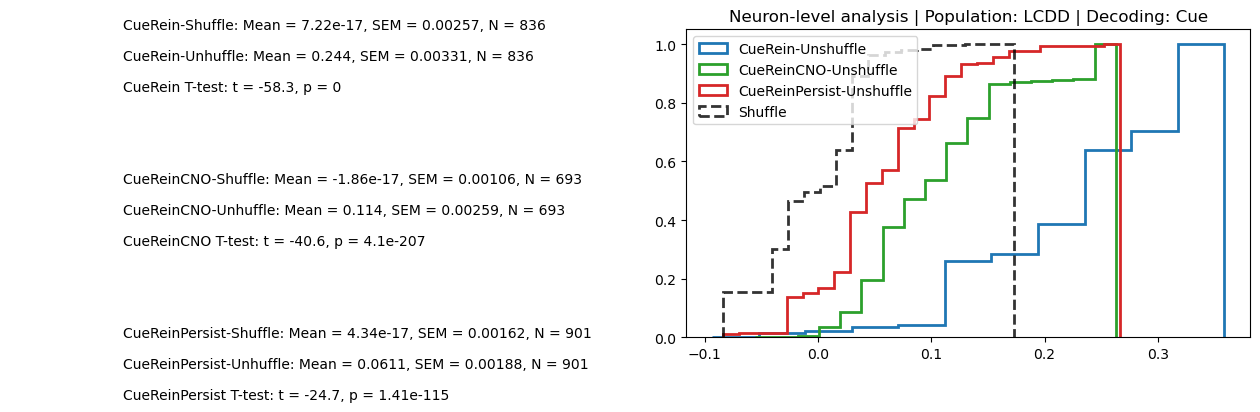

In [28]:
#cdf plots for neurons

population = 'LCDD'
groups = ['CueRein', 'CueReinCNO', 'CueReinPersist']
colors = (['tab:blue'], ['tab:green'],['tab:red'])
ls = ['--','solid']

d = {}
d[variable] = {}
all_shuffle_for_variable=[]
fig, ax = plt.subplots(1, 2, figsize = (16,4))
for g, group in enumerate(groups):
    d[variable][group] = {}
    d[variable][group] = np.array(np.load(os.path.join(iteration_dictionaries,
                                                        'LC-PrL-DREADDs_SA_%s_%s_accuracy_dict.npy'%(group, date)), 
                                                        allow_pickle = True).astype(float))
    temp_unshuffle_nonans, temp_shuffle_nonans = ([],[])
    temp_unshuffle,temp_shuffle = (d[variable][group][0],d[variable][group][1])

    for i in range(len(temp_unshuffle)):
        if np.isfinite(temp_unshuffle[i]):
            temp_unshuffle_nonans = np.append(temp_unshuffle_nonans, temp_unshuffle[i])
    for i in range(len(temp_shuffle)):
        if np.isfinite(temp_shuffle[i]):
            temp_shuffle_nonans = np.append(temp_shuffle_nonans, temp_shuffle[i])
            
    #normalize data
    mean_shuffle = np.mean(temp_shuffle_nonans)
    temp_unshuffle_nonans = temp_unshuffle_nonans - mean_shuffle
    temp_shuffle_nonans = temp_shuffle_nonans - mean_shuffle
    
    plt.hist((temp_unshuffle_nonans),  density=True, cumulative=True,\
        label = '%s-Unshuffle'%(group), histtype='step',\
        linestyle = ('-'), bins = 'auto', color = colors[g], linewidth=2)

    all_shuffle_for_variable = np.append(all_shuffle_for_variable, d[variable][group][1])
    if g == len(groups)-1:
        plt.hist((temp_shuffle_nonans),  density=True, cumulative=True,\
            label = 'Shuffle', histtype='step',\
            linestyle = ('--'), bins ='auto', color = 'k', alpha=.8,linewidth=2)
            
    ax[0].text(.2,1-g*.5,'%s-Shuffle: Mean = '%(group) + '{0:.3g}'.format(np.mean(temp_shuffle_nonans)) + \
        ', SEM = ' + '{0:.3g}'.format(stats.sem(temp_shuffle_nonans)) + ', N = ' + '{0:.3g}'.format(len(temp_shuffle_nonans)))
    ax[0].text(.2, .9-g*.5,'%s-Unhuffle: Mean = '%(group) + '{0:.3g}'.format(np.mean(temp_unshuffle_nonans)) + \
        ', SEM = ' + '{0:.3g}'.format(stats.sem(temp_unshuffle_nonans)) + ', N = ' + '{0:.3g}'.format(len(temp_unshuffle_nonans)))
    t, p = stats.ttest_ind(temp_shuffle_nonans,\
        temp_unshuffle_nonans, equal_var=False)
    ax[0].text(.2, .8-g*.5, '%s T-test: t = '%(group) + '{0:.3g}'.format(t) + ', p = ' + '{0:.3g}'.format(p))

ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['left'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)

plt.legend(loc=2)
plt.title('%s-level analysis | Population: %s | Decoding: %s'%(decoding, population, variable))

plt.savefig(os.path.join(iteration_results, 'LC-PrL-DREADDs_SA_%s-%s.PDF'%(group, population)), format = 'PDF')

plt.show()

Group: CueRein


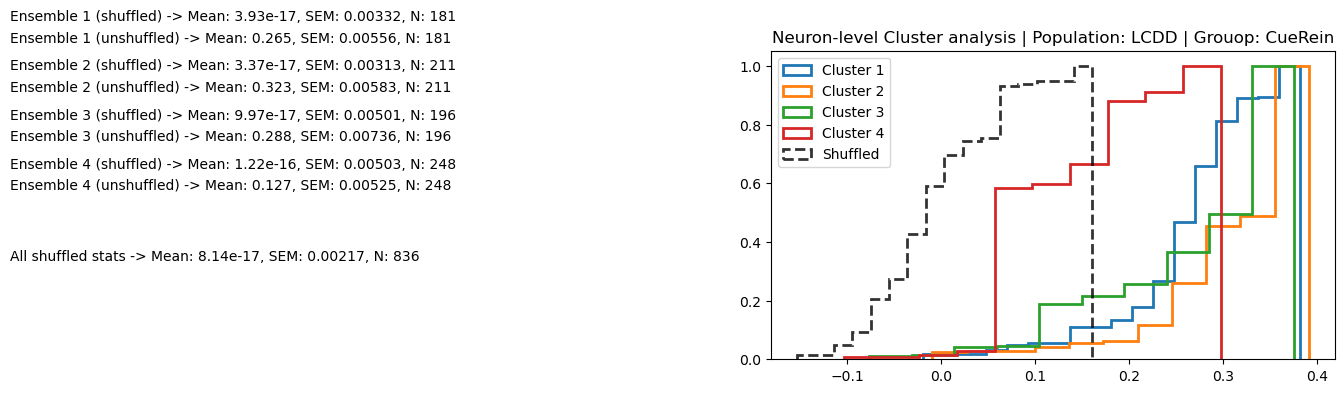

Group: CueReinCNO


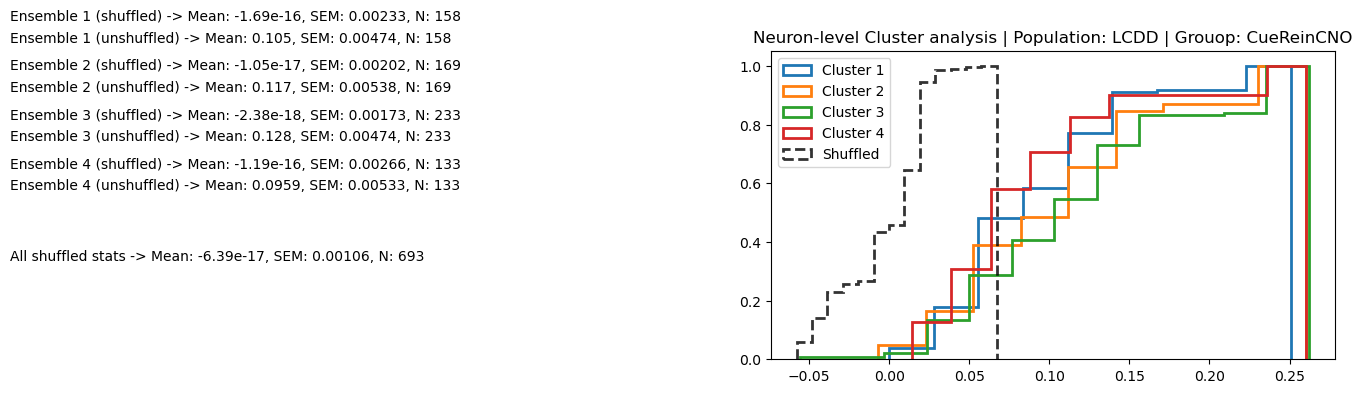

Group: CueReinPersist


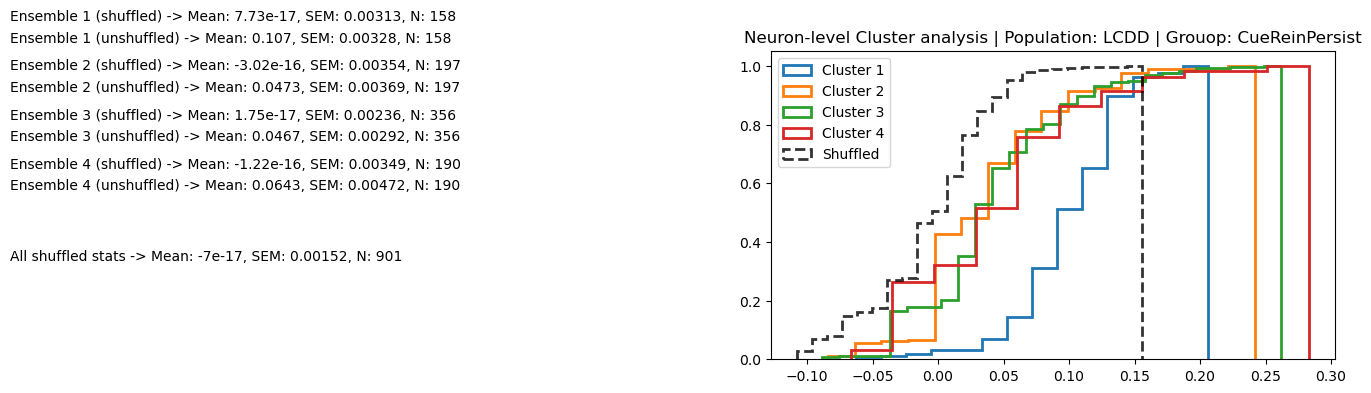

In [27]:
#cdf plots for clusters

population = 'LCDD'
groups = ['CueRein', 'CueReinCNO', 'CueReinPersist']
dir_list = [cueRein_dir, cueReinCNO_dir, cueReinPersist_dir]
color = (['k'],['tab:red'], ['tab:green'],['tab:blue'], ['tab:yellow'])
ls = ['--','solid']

for index in range(len(groups)):
    group = groups[index]
    newlabels = np.load((os.path.join(dir_list[index], 'cluster_list_per_session_CueTests Control.npy')))

    dict_file = np.load(os.path.join(iteration_dictionaries, 
                                     'LC-PrL-DREADDs_SA_%s_%s_accuracy_dict.npy'%(group, date)),allow_pickle = True).astype(float)
    print('Group:', group)
    d = {}
    d[variable]={}
    all_shuffle_for_variable = []
    fig, ax = plt.subplots(1, 2, figsize = (16,4))
    for cluster in range(numclusters):
        d[variable][cluster] = {}
        file_max = len(dict_file[1])
        fit = np.array(newlabels[:file_max])
        temp_array = np.squeeze(dict_file[:,np.where(fit==cluster)[0]])
        d[variable][cluster] = temp_array

        shuffled_mean = np.nanmean(d[variable][cluster][1])
        normalized_unshuffled = d[variable][cluster][0] - shuffled_mean
        normalized_shuffled = d[variable][cluster][1] - shuffled_mean
        all_shuffle_for_variable = np.append(all_shuffle_for_variable, normalized_shuffled)

        plt.hist((normalized_unshuffled), density=True, cumulative=True,\
                            label = ['Cluster %s'%(cluster+1)], histtype='step', linestyle = '-',\
                            bins = 'auto', linewidth=2)
        ax[0].text(-0.15, (1.1-cluster*.16), 
                ('Ensemble '+str(cluster+1)+' (shuffled) -> ' +
                'Mean: ' + '%.3g'%(np.nanmean((normalized_shuffled))) +
                ', SEM: ' + '%.3g'%(stats.sem(normalized_shuffled[np.where(np.isfinite(normalized_shuffled))]))) +
                ', N: ' + str(len(normalized_shuffled)))
        ax[0].text(-0.15, 1.03-cluster*.16, 
                ('Ensemble '+str(cluster+1)+' (unshuffled) -> ' +
                'Mean: ' + '%.3g'%(np.nanmean((normalized_unshuffled))) +
                ', SEM: ' + '%.3g'%(stats.sem(normalized_unshuffled[np.where(np.isfinite(normalized_unshuffled))]))) +
                ', N: ' + str(len(normalized_unshuffled)))
        if cluster == len(uniquelabels)-1:
            plt.hist((all_shuffle_for_variable), density=True, cumulative=True,\
                label = ['Shuffled'], histtype='step', linestyle = '--',\
                bins = 'auto', linewidth=2, color = 'k', alpha = .8)
            ax[0].text(-0.15, .8-cluster*.16, 
                ('All shuffled stats -> ' +
                'Mean: ' + '%.3g'%(np.nanmean(all_shuffle_for_variable)) +
                ', SEM: ' + '%.3g'%(stats.sem(all_shuffle_for_variable[np.where(np.isfinite(all_shuffle_for_variable))]))) +
                ', N: ' + str(len(all_shuffle_for_variable)))

        ax[0].get_xaxis().set_visible(False)
        ax[0].get_yaxis().set_visible(False)
        ax[0].spines['top'].set_visible(False)
        ax[0].spines['right'].set_visible(False)
        ax[0].spines['left'].set_visible(False)
        ax[0].spines['bottom'].set_visible(False)

        plt.legend(loc=2)
        plt.title('%s-level Cluster analysis | Population: %s | Grouop: %s'%(decoding, population, group))
    plt.savefig(os.path.join(iteration_results, 'LC-PrL-DREADDs_SA_%s-%s_Cluster.PDF'%(group, population)), format = 'PDF')
    plt.show()

#### auROC

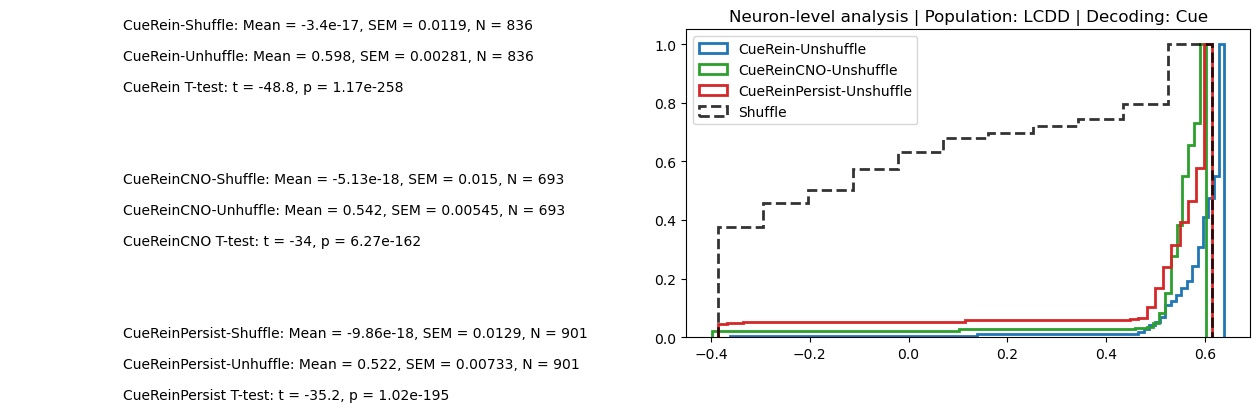

In [29]:
#cdf plots for neurons

population = 'LCDD'
groups = ['CueRein', 'CueReinCNO', 'CueReinPersist']
colors = (['tab:blue'], ['tab:green'],['tab:red'])
ls = ['--','solid']

d = {}
d[variable] = {}
all_shuffle_for_variable=[]
fig, ax = plt.subplots(1, 2, figsize = (16,4))
for g, group in enumerate(groups):
    d[variable][group] = {}
    d[variable][group] = np.array(np.load(os.path.join(iteration_dictionaries,
                                                        'LC-PrL-DREADDs_SA_%s_%s_auROC_dict.npy'%(group, date)), 
                                                        allow_pickle = True).astype(float))
    temp_unshuffle_nonans, temp_shuffle_nonans = ([],[])
    temp_unshuffle,temp_shuffle = (d[variable][group][0],d[variable][group][1])

    for i in range(len(temp_unshuffle)):
        if np.isfinite(temp_unshuffle[i]):
            temp_unshuffle_nonans = np.append(temp_unshuffle_nonans, temp_unshuffle[i])
    for i in range(len(temp_shuffle)):
        if np.isfinite(temp_shuffle[i]):
            temp_shuffle_nonans = np.append(temp_shuffle_nonans, temp_shuffle[i])
            
    #normalize data
    mean_shuffle = np.mean(temp_shuffle_nonans)
    temp_unshuffle_nonans = temp_unshuffle_nonans - mean_shuffle
    temp_shuffle_nonans = temp_shuffle_nonans - mean_shuffle
    
    plt.hist((temp_unshuffle_nonans),  density=True, cumulative=True,\
        label = '%s-Unshuffle'%(group), histtype='step',\
        linestyle = ('-'), bins = 'auto', color = colors[g], linewidth=2)

    all_shuffle_for_variable = np.append(all_shuffle_for_variable, d[variable][group][1])
    if g == len(groups)-1:
        plt.hist((temp_shuffle_nonans),  density=True, cumulative=True,\
            label = 'Shuffle', histtype='step',\
            linestyle = ('--'), bins ='auto', color = 'k', alpha=.8,linewidth=2)
            
    ax[0].text(.2,1-g*.5,'%s-Shuffle: Mean = '%(group) + '{0:.3g}'.format(np.mean(temp_shuffle_nonans)) + \
        ', SEM = ' + '{0:.3g}'.format(stats.sem(temp_shuffle_nonans)) + ', N = ' + '{0:.3g}'.format(len(temp_shuffle_nonans)))
    ax[0].text(.2, .9-g*.5,'%s-Unhuffle: Mean = '%(group) + '{0:.3g}'.format(np.mean(temp_unshuffle_nonans)) + \
        ', SEM = ' + '{0:.3g}'.format(stats.sem(temp_unshuffle_nonans)) + ', N = ' + '{0:.3g}'.format(len(temp_unshuffle_nonans)))
    t, p = stats.ttest_ind(temp_shuffle_nonans,\
        temp_unshuffle_nonans, equal_var=False)
    ax[0].text(.2, .8-g*.5, '%s T-test: t = '%(group) + '{0:.3g}'.format(t) + ', p = ' + '{0:.3g}'.format(p))

ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['left'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)

plt.legend(loc=2)
plt.title('%s-level analysis | Population: %s | Decoding: %s'%(decoding, population, variable))

plt.savefig(os.path.join(iteration_results, 'LC-PrL-DREADDs_SA_%s-%s_auROC.PDF'%(group, population)), format = 'PDF')

plt.show()

Group: CueRein


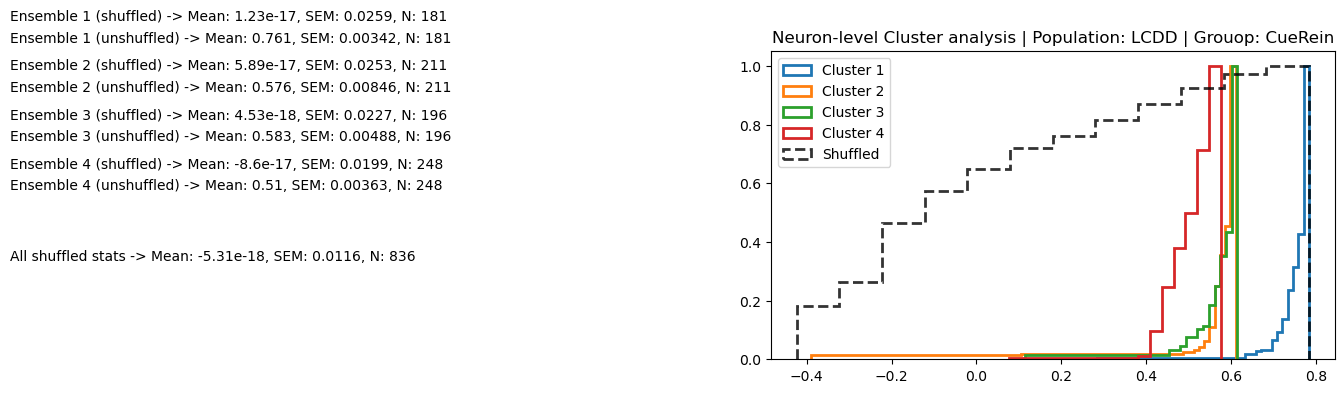

Group: CueReinCNO


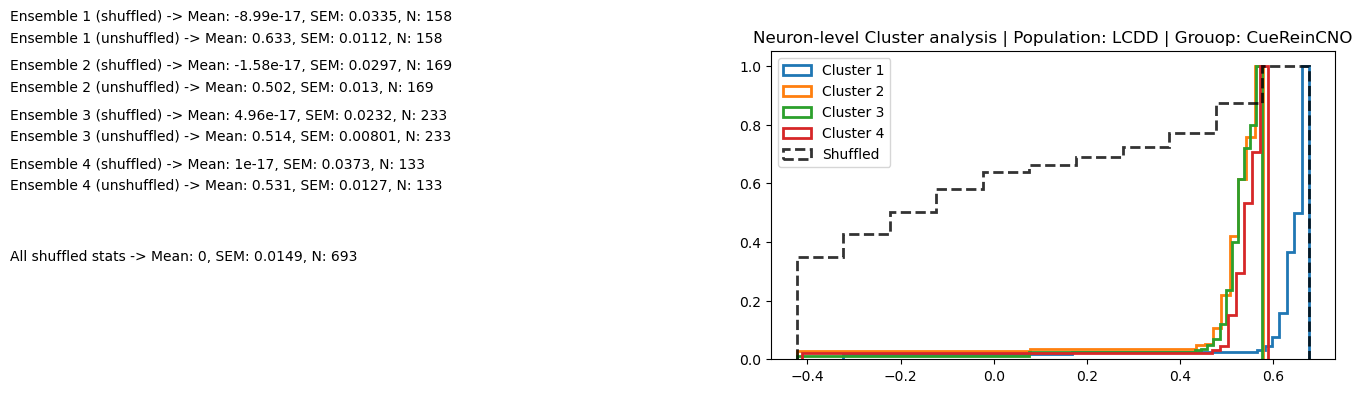

Group: CueReinPersist


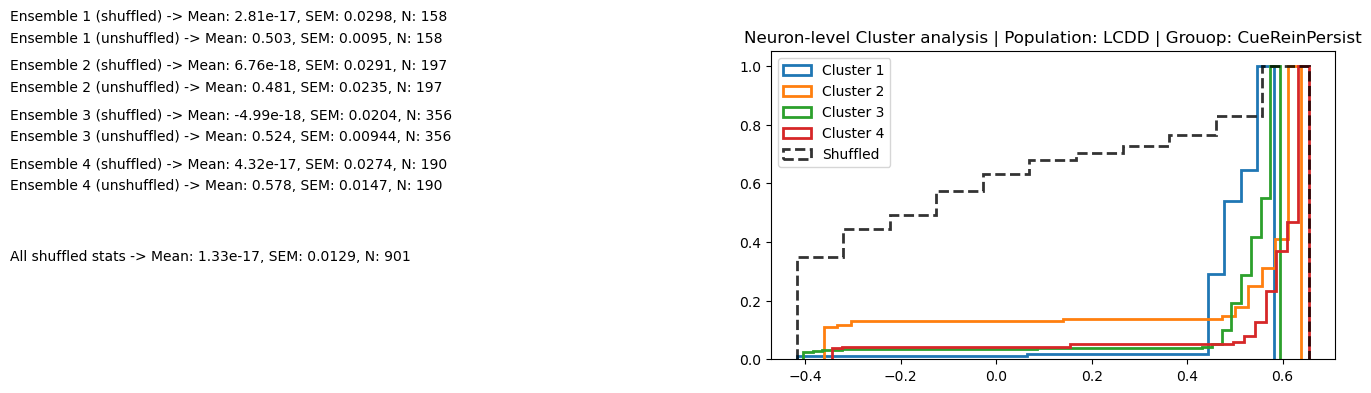

In [30]:
#cdf plots for clusters

population = 'LCDD'
groups = ['CueRein', 'CueReinCNO', 'CueReinPersist']
dir_list = [cueRein_dir, cueReinCNO_dir, cueReinPersist_dir]
color = (['k'],['tab:red'], ['tab:green'],['tab:blue'], ['tab:yellow'])
ls = ['--','solid']

for index in range(len(groups)):
    group = groups[index]
    newlabels = np.load((os.path.join(dir_list[index], 'cluster_list_per_session_CueTests Control.npy')))

    dict_file = np.load(os.path.join(iteration_dictionaries, 
                                     'LC-PrL-DREADDs_SA_%s_%s_auROC_dict.npy'%(group, date)),allow_pickle = True).astype(float)
    print('Group:', group)
    d = {}
    d[variable]={}
    all_shuffle_for_variable = []
    fig, ax = plt.subplots(1, 2, figsize = (16,4))
    for cluster in range(numclusters):
        d[variable][cluster] = {}
        file_max = len(dict_file[1])
        fit = np.array(newlabels[:file_max])
        temp_array = np.squeeze(dict_file[:,np.where(fit==cluster)[0]])
        d[variable][cluster] = temp_array

        shuffled_mean = np.nanmean(d[variable][cluster][1])
        normalized_unshuffled = d[variable][cluster][0] - shuffled_mean
        normalized_shuffled = d[variable][cluster][1] - shuffled_mean
        all_shuffle_for_variable = np.append(all_shuffle_for_variable, normalized_shuffled)

        plt.hist((normalized_unshuffled), density=True, cumulative=True,\
                            label = ['Cluster %s'%(cluster+1)], histtype='step', linestyle = '-',\
                            bins = 'auto', linewidth=2)
        ax[0].text(-0.15, (1.1-cluster*.16), 
                ('Ensemble '+str(cluster+1)+' (shuffled) -> ' +
                'Mean: ' + '%.3g'%(np.nanmean((normalized_shuffled))) +
                ', SEM: ' + '%.3g'%(stats.sem(normalized_shuffled[np.where(np.isfinite(normalized_shuffled))]))) +
                ', N: ' + str(len(normalized_shuffled)))
        ax[0].text(-0.15, 1.03-cluster*.16, 
                ('Ensemble '+str(cluster+1)+' (unshuffled) -> ' +
                'Mean: ' + '%.3g'%(np.nanmean((normalized_unshuffled))) +
                ', SEM: ' + '%.3g'%(stats.sem(normalized_unshuffled[np.where(np.isfinite(normalized_unshuffled))]))) +
                ', N: ' + str(len(normalized_unshuffled)))
        if cluster == len(uniquelabels)-1:
            plt.hist((all_shuffle_for_variable), density=True, cumulative=True,\
                label = ['Shuffled'], histtype='step', linestyle = '--',\
                bins = 'auto', linewidth=2, color = 'k', alpha = .8)
            ax[0].text(-0.15, .8-cluster*.16, 
                ('All shuffled stats -> ' +
                'Mean: ' + '%.3g'%(np.nanmean(all_shuffle_for_variable)) +
                ', SEM: ' + '%.3g'%(stats.sem(all_shuffle_for_variable[np.where(np.isfinite(all_shuffle_for_variable))]))) +
                ', N: ' + str(len(all_shuffle_for_variable)))

        ax[0].get_xaxis().set_visible(False)
        ax[0].get_yaxis().set_visible(False)
        ax[0].spines['top'].set_visible(False)
        ax[0].spines['right'].set_visible(False)
        ax[0].spines['left'].set_visible(False)
        ax[0].spines['bottom'].set_visible(False)

        plt.legend(loc=2)
        plt.title('%s-level Cluster analysis | Population: %s | Grouop: %s'%(decoding, population, group))
    plt.savefig(os.path.join(iteration_results, 'LC-PrL-DREADDs_SA_%s-%s_Cluster_auROC.PDF'%(group, population)), format = 'PDF')
    plt.show()